In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 82.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import mne
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Fuzzy matching (old)

In [ ]:
import os
import numpy as np
import mne
from difflib import get_close_matches
from mne import filter

def find_closest_hypnogram(psg_filename, hypnogram_files):
    """Finds the closest matching hypnogram file for a given PSG file."""
    base_name = psg_filename.replace('-PSG.edf', '')
    matches = get_close_matches(base_name, hypnogram_files, n=1, cutoff=0.4)

    if matches:
        return matches[0]
    return None

def denoise_eeg(eeg_data, low_freq=0.5, high_freq=40, fs=100):
    """Applies a bandpass filter to the EEG data."""
    eeg_denoised = filter.filter_data(eeg_data, sfreq=fs, l_freq=low_freq, h_freq=high_freq)
    return eeg_denoised

def load_data(data_path):
    psg_files = sorted([f for f in os.listdir(data_path) if '-PSG.edf' in f])
    hypnogram_files = sorted([f for f in os.listdir(data_path) if '-Hypnogram.edf' in f])

    X, y = [], []

    for psg_file in psg_files:
        edf_path = os.path.join(data_path, psg_file)
        hypnogram_file = find_closest_hypnogram(psg_file, hypnogram_files)

        if not hypnogram_file:
            print(f"No hypnogram found for {psg_file}. Skipping...")
            continue

        hypnogram_path = os.path.join(data_path, hypnogram_file)
        print(f"Matching {psg_file} with {hypnogram_file}")

        raw = mne.io.read_raw_edf(edf_path, preload=True)
        raw.pick_channels(['EEG Fpz-Cz'])
        raw.resample(100)
        eeg_data = raw.get_data()[0]

        eeg_data_30s = eeg_data[:12000]

        eeg_data_denoised = denoise_eeg(eeg_data_30s)

        annotations = mne.read_annotations(hypnogram_path)
        if len(annotations) == 0:
            print(f"No annotations found in {hypnogram_file}. Skipping...")
            continue

        sleep_stages = []
        for desc, onset, duration in zip(annotations.description, annotations.onset, annotations.duration):
            if 'Sleep stage' in desc:
                try:
                    stage = int(desc.replace('Sleep stage ', ''))
                    num_epochs = int(duration / 30)
                    sleep_stages.extend([stage] * num_epochs)
                except ValueError:
                    continue

        if len(sleep_stages) == 0:
            print(f"No valid sleep stages extracted from {hypnogram_file}. Skipping...")
            continue

        epoch_length = 30 * 100
        num_epochs = min(len(eeg_data_denoised) // epoch_length, len(sleep_stages))

        for i in range(num_epochs):
            X.append(eeg_data_denoised[i * epoch_length:(i + 1) * epoch_length])
            y.append(sleep_stages[i])

    return np.array(X), np.array(y)

data_path = "/content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette"
X, y = load_data(data_path)

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")

Matching SC4001E0-PSG.edf with SC4001EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4002E0-PSG.edf with SC4002EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structu

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4011E0-PSG.edf with SC4011EH-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4012E0-PSG.edf with SC4012EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4541F0-PSG.edf with SC4541FA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4541F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8219999  =      0.000 ... 82199.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4542F0-PSG.edf with SC4542FW-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4542F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4551F0-PSG.edf with SC4551FC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4551F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8315999  =      0.000 ... 83159.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4552F0-PSG.edf with SC4552FW-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4552F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4561F0-PSG.edf with SC4571FV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4561F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8111999  =      0.000 ... 81119.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4562F0-PSG.edf with SC4562FJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4562F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8399999  =      0.000 ... 83999.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4571F0-PSG.edf with SC4571FV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4571F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4572F0-PSG.edf with SC4572FC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4572F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8639999  =      0.000 ... 86399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4581G0-PSG.edf with SC4581GM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4581G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8213999  =      0.000 ... 82139.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4582G0-PSG.edf with SC4582GP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4582G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 79019.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4591G0-PSG.edf with SC4591GY-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4591G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4592G0-PSG.edf with SC4592GY-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4592G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6119999  =      0.000 ... 61199.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4601E0-PSG.edf with SC4601EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4601E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8189999  =      0.000 ... 81899.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4602E0-PSG.edf with SC4602EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4602E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8399999  =      0.000 ... 83999.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4611E0-PSG.edf with SC4611EG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4611E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4612E0-PSG.edf with SC4612EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4612E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8189999  =      0.000 ... 81899.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4621E0-PSG.edf with SC4621EV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4621E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7835999  =      0.000 ... 78359.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4622E0-PSG.edf with SC4622EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4622E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8567999  =      0.000 ... 85679.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4631E0-PSG.edf with SC4631EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4631E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8273999  =      0.000 ... 82739.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4632E0-PSG.edf with SC4632EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4632E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8543999  =      0.000 ... 85439.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4641E0-PSG.edf with SC4641EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4641E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4642E0-PSG.edf with SC4642EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4642E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8369999  =      0.000 ... 83699.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4651E0-PSG.edf with SC4651EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4651E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8579999  =      0.000 ... 85799.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4652E0-PSG.edf with SC4652EG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4652E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8519999  =      0.000 ... 85199.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4661E0-PSG.edf with SC4661EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4661E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8219999  =      0.000 ... 82199.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4662E0-PSG.edf with SC4662EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4662E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4671G0-PSG.edf with SC4671GJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4671G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4672G0-PSG.edf with SC4672GV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4672G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7739999  =      0.000 ... 77399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4701E0-PSG.edf with SC4701EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4701E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4702E0-PSG.edf with SC4702EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4702E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7871999  =      0.000 ... 78719.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4711E0-PSG.edf with SC4711EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4711E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8189999  =      0.000 ... 81899.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4712E0-PSG.edf with SC4712EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4712E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4721E0-PSG.edf with SC4721EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4721E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7025999  =      0.000 ... 70259.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4722E0-PSG.edf with SC4722EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4722E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8237999  =      0.000 ... 82379.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4731E0-PSG.edf with SC4731EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4731E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4732E0-PSG.edf with SC4732EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4732E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559999  =      0.000 ... 75599.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4741E0-PSG.edf with SC4741EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4741E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8069999  =      0.000 ... 80699.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4742E0-PSG.edf with SC4742EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4742E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4751E0-PSG.edf with SC4751EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4751E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4752E0-PSG.edf with SC4752EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4752E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7409999  =      0.000 ... 74099.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4761E0-PSG.edf with SC4761EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4761E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7889999  =      0.000 ... 78899.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4762E0-PSG.edf with SC4762EG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4762E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4771G0-PSG.edf with SC4771GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4771G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4772G0-PSG.edf with SC4772GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4772G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6725999  =      0.000 ... 67259.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4801G0-PSG.edf with SC4801GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4801G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4802G0-PSG.edf with SC4802GV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4802G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4811G0-PSG.edf with SC4811GG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4811G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7205999  =      0.000 ... 72059.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4812G0-PSG.edf with SC4812GV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4812G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7247999  =      0.000 ... 72479.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4821G0-PSG.edf with SC4821GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4821G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Matching SC4822G0-PSG.edf with SC4822GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4822G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 se

<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-3c424cb3c13f>:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)


Final dataset shape: X=(216, 3000), y=(216,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"\nFinal dataset shape: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")


Final dataset shape: X_train=(137, 3000), X_test=(44, 3000), y_train=(137,), y_test=(44,)


Visualize

Enter the full path to the PSG (EEG) file: /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4001E0-PSG.edf
Enter the full path to the Hypnogram file: /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4001EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-6-06e77fd06340>:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
<ipython-input-6-06e77fd06340>:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
<ipython-input-6-06e77fd06340>:21: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True)



All parameters (channels) present in the dataset:
1. EEG Fpz-Cz
2. EEG Pz-Oz
3. EOG horizontal
4. Resp oro-nasal
5. EMG submental
6. Temp rectal
7. Event marker
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-6-06e77fd06340>:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
<ipython-input-6-06e77fd06340>:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
<ipython-input-6-06e77fd06340>:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.

Extracted Parameters:
 - Sleep Stage Parameter (EEG channel): EEG Fpz-Cz
 - Sleep Disorder Parameters (additional channels):
    * Resp oro-nasal

Final dataset shape: X=(528, 3000), y=(528,)


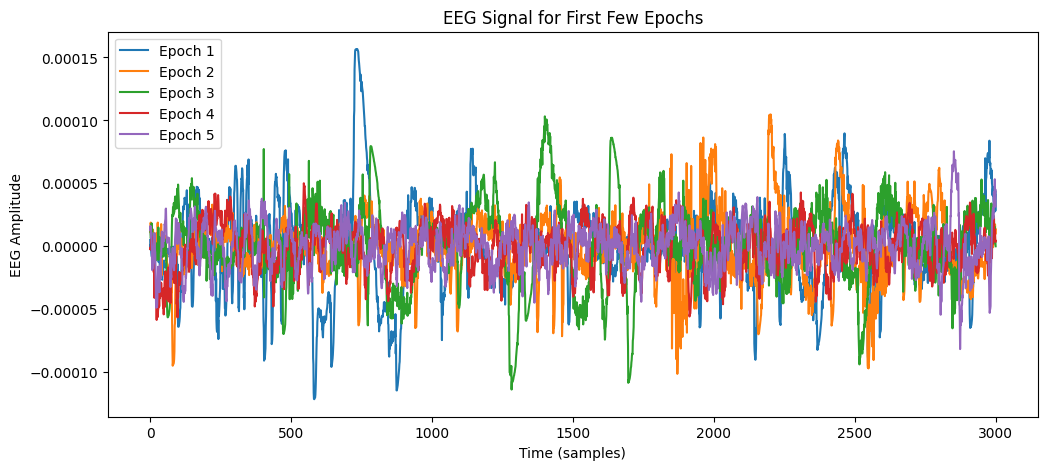

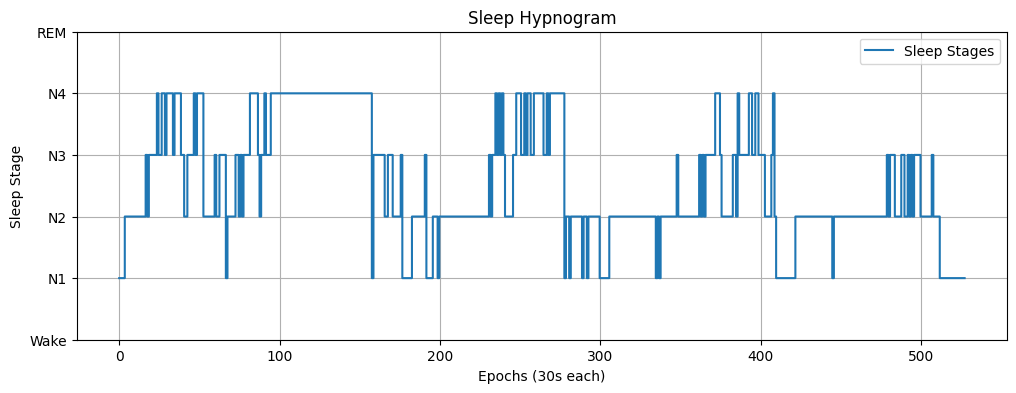

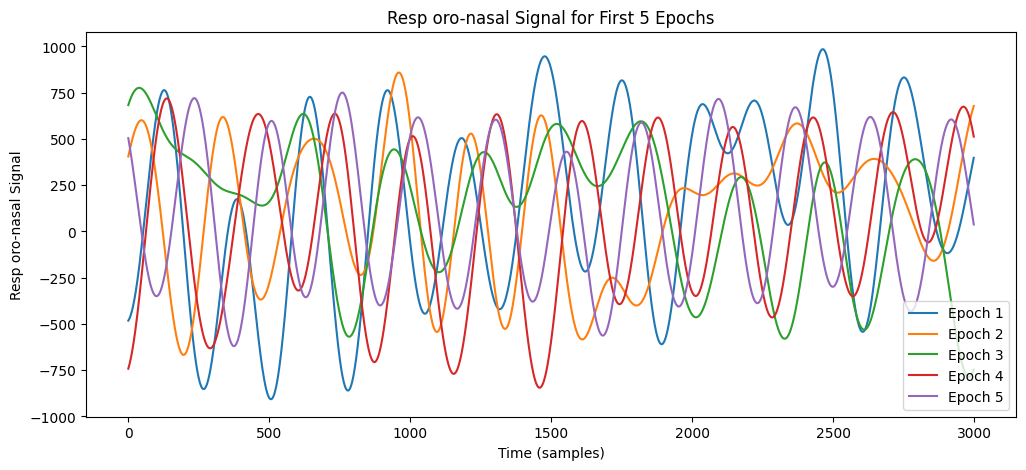

In [ ]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from difflib import get_close_matches

def find_closest_hypnogram(psg_filename, hypnogram_files):
    """Finds the closest matching hypnogram file for a given PSG file."""
    base_name = psg_filename.replace('-PSG.edf', '')
    matches = get_close_matches(base_name, hypnogram_files, n=1, cutoff=0.4)
    if matches:
        return matches[0]
    return None

def display_all_parameters(psg_path):
    """
    Loads the PSG dataset and displays all parameter (channel) names.
    """
    try:
        raw = mne.io.read_raw_edf(psg_path, preload=True)
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    print("\nAll parameters (channels) present in the dataset:")
    for idx, channel in enumerate(raw.ch_names, start=1):
        print(f"{idx}. {channel}")

def load_data(psg_path, hypnogram_path):
    """
    Loads EEG data from PSG and corresponding Hypnogram file.

    Also loads additional channels (if available) that are known to affect sleep disorders.

    Returns:
      X: EEG epochs (30-second segments)
      y: Sleep stage labels
      disorder_epochs: Dictionary containing epochs for each additional channel
      channels_info: Tuple of (sleep_stage_channel, disorder_channels) used in this dataset
    """
    raw = mne.io.read_raw_edf(psg_path, preload=True)

    sleep_stage_channel = 'EEG Fpz-Cz'
    if sleep_stage_channel not in raw.ch_names:
        print(f"EEG channel {sleep_stage_channel} not found. Exiting...")
        return None, None, None, None

    raw_eeg = raw.copy().pick_channels([sleep_stage_channel])
    raw_eeg.resample(100)
    eeg_data = raw_eeg.get_data()[0]
    disorder_channels = []
    candidate_keywords = ['Resp', 'Airflow', 'Chest', 'Abdomen', 'SpO2', 'Oxy', 'ECG', 'Heart']
    for ch in raw.ch_names:
        if ch == sleep_stage_channel:
            continue
        for keyword in candidate_keywords:
            if keyword.lower() in ch.lower():
                disorder_channels.append(ch)
                break

    disorder_data = {}
    if disorder_channels:
        raw_disorder = raw.copy().pick_channels(disorder_channels)
        raw_disorder.resample(100)
        data_array = raw_disorder.get_data()
        for idx, ch in enumerate(disorder_channels):
            disorder_data[ch] = data_array[idx]
    else:
        print("No additional disorder parameter channels found.")
        disorder_data = None

    annotations = mne.read_annotations(hypnogram_path)
    if len(annotations) == 0:
        print(f"No annotations found in {hypnogram_path}. Exiting...")
        return None, None, None, None

    sleep_stages = []
    for desc, onset, duration in zip(annotations.description, annotations.onset, annotations.duration):
        if 'Sleep stage' in desc:
            try:
                stage = int(desc.replace('Sleep stage ', ''))
                num_epochs = int(duration / 30)
                sleep_stages.extend([stage] * num_epochs)
            except ValueError:
                continue

    if len(sleep_stages) == 0:
        print(f"No valid sleep stages extracted from {hypnogram_path}. Exiting...")
        return None, None, None, None

    epoch_length = 30 * 100
    num_epochs = min(len(eeg_data) // epoch_length, len(sleep_stages))
    X = []
    disorder_epochs = {} if disorder_data is not None else None

    for i in range(num_epochs):
        X.append(eeg_data[i * epoch_length:(i + 1) * epoch_length])
        if disorder_data is not None:
            for ch in disorder_data:
                if ch not in disorder_epochs:
                    disorder_epochs[ch] = []
                disorder_epochs[ch].append(disorder_data[ch][i * epoch_length:(i + 1) * epoch_length])

    X = np.array(X)
    y = np.array(sleep_stages[:num_epochs])

    if disorder_epochs is not None:
        for ch in disorder_epochs:
            disorder_epochs[ch] = np.array(disorder_epochs[ch])

    channels_info = (sleep_stage_channel, disorder_channels)
    return X, y, disorder_epochs, channels_info

def plot_eeg_signal(eeg_data, num_epochs=5):
    """Plots EEG signal for the first few epochs."""
    plt.figure(figsize=(12, 5))
    for i in range(min(num_epochs, len(eeg_data))):
        plt.plot(eeg_data[i], label=f'Epoch {i+1}')
    plt.xlabel('Time (samples)')
    plt.ylabel('EEG Amplitude')
    plt.title('EEG Signal for First Few Epochs')
    plt.legend()
    plt.show()

def plot_hypnogram(sleep_stages):
    """Plots the hypnogram (sleep stage transitions)."""
    plt.figure(figsize=(12, 4))
    plt.step(range(len(sleep_stages)), sleep_stages, where='mid', label="Sleep Stages")
    plt.xlabel("Epochs (30s each)")
    plt.ylabel("Sleep Stage")
    plt.title("Sleep Hypnogram")
    plt.yticks([0, 1, 2, 3, 4, 5], ["Wake", "N1", "N2", "N3", "N4", "REM"])  # Adjust based on dataset
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_disorder_parameters(disorder_epochs, num_epochs=5):
    """Plots additional channels (e.g., respiration, SpO2, ECG) for the first few epochs."""
    if disorder_epochs is None:
        print("No disorder parameters to display.")
        return

    for ch, epochs in disorder_epochs.items():
        plt.figure(figsize=(12, 5))
        for i in range(min(num_epochs, epochs.shape[0])):
            plt.plot(epochs[i], label=f'Epoch {i+1}')
        plt.xlabel('Time (samples)')
        plt.ylabel(f'{ch} Signal')
        plt.title(f'{ch} Signal for First {num_epochs} Epochs')
        plt.legend()
        plt.show()

def display_extracted_parameters(sleep_stage_channel, disorder_channels):
    """Displays the parameter names used for sleep stage and sleep disorders."""
    print("\nExtracted Parameters:")
    print(f" - Sleep Stage Parameter (EEG channel): {sleep_stage_channel}")
    if disorder_channels:
        print(" - Sleep Disorder Parameters (additional channels):")
        for ch in disorder_channels:
            print(f"    * {ch}")
    else:
        print(" - No additional sleep disorder parameters were found.")

psg_path = input("Enter the full path to the PSG (EEG) file: ").strip()
hypnogram_path = input("Enter the full path to the Hypnogram file: ").strip()

if not os.path.exists(psg_path) or not os.path.exists(hypnogram_path):
    print("Error: One or both file paths are incorrect. Please check and try again.")
else:
    display_all_parameters(psg_path)

    X, y, disorder_epochs, channels_info = load_data(psg_path, hypnogram_path)
    if channels_info is not None:
        sleep_stage_channel, disorder_channels = channels_info
        display_extracted_parameters(sleep_stage_channel, disorder_channels)

    if X is not None and y is not None:
        print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")

        plot_eeg_signal(X[:5])

        plot_hypnogram(y)

        plot_disorder_parameters(disorder_epochs)

In [ ]:
pip install networkx rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 6.9 MB/s eta 0:00:00


Enter the full path to the PSG (EDF) file: /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4822G0-PSG.edf
Enter the full path to the Hypnogram file: /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4822GC-Hypnogram.edf


<ipython-input-13-a8b04253ae3a>:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
<ipython-input-13-a8b04253ae3a>:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
<ipython-input-13-a8b04253ae3a>:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


PSG Channels (Parameters): ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
Unique Sleep Stage Labels: ['1', '2', '3', '4', '?', 'R', 'W']


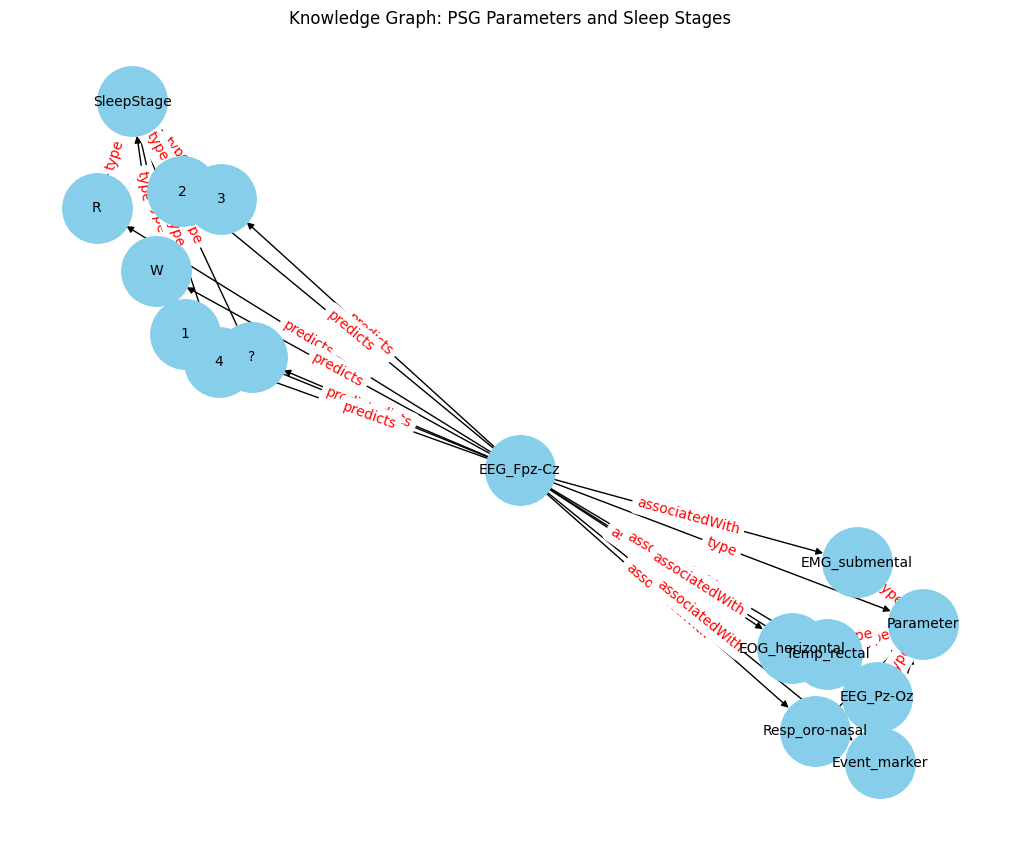

In [ ]:
import os
import rdflib
import networkx as nx
import matplotlib.pyplot as plt
import mne

def get_parameters(psg_path, hypnogram_path):
    """
    Extracts parameters from the PSG file and sleep stage labels from the hypnogram.

    Returns:
      psg_channels: List of all channel names (parameters) from the PSG file.
      unique_sleep_labels: Sorted list of unique sleep stage labels from the hypnogram.
    """
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    psg_channels = raw.ch_names

    annotations = mne.read_annotations(hypnogram_path)
    sleep_labels = []
    for desc in annotations.description:
        if "Sleep stage" in desc:
            stage = desc.replace("Sleep stage", "").strip()
            sleep_labels.append(stage)
    unique_sleep_labels = sorted(set(sleep_labels))

    return psg_channels, unique_sleep_labels

def build_knowledge_graph(psg_channels, sleep_labels, main_channel="EEG Fpz-Cz"):
    """
    Builds an RDF knowledge graph where:
      - Each PSG channel becomes a node of type 'Parameter'
      - Each unique sleep stage label becomes a node of type 'SleepStage'
      - The main sleep stage channel (default "EEG Fpz-Cz") is linked with:
          • all other PSG parameters (via the 'associatedWith' relation)
          • all sleep stage labels (via the 'predicts' relation)

    Returns:
      g: The RDF graph.
      namespace: The defined namespace.
    """
    g = rdflib.Graph()
    namespace = rdflib.Namespace("http://example.org/sleep#")
    g.bind("sleep", namespace)

    for channel in psg_channels:
        node_name = channel.replace(" ", "_")
        g.add((namespace[node_name], rdflib.RDF.type, namespace.Parameter))

    for label in sleep_labels:
        node_name = label.replace(" ", "_")
        g.add((namespace[node_name], rdflib.RDF.type, namespace.SleepStage))

    main_node_name = main_channel.replace(" ", "_")
    if main_channel not in psg_channels:
        print(f"Warning: Main sleep stage channel '{main_channel}' not found in PSG channels.")
    else:
        for channel in psg_channels:
            if channel != main_channel:
                channel_node = channel.replace(" ", "_")
                g.add((namespace[main_node_name], namespace.associatedWith, namespace[channel_node]))
        for label in sleep_labels:
            label_node = label.replace(" ", "_")
            g.add((namespace[main_node_name], namespace.predicts, namespace[label_node]))

    return g, namespace

def convert_and_plot_graph(g, namespace):
    """
    Converts the RDF graph to a NetworkX DiGraph and plots it.
    Edges are labeled by the predicate (relation) local name.
    """
    G = nx.DiGraph()
    for s, p, o in g:
        s_name = s.split("#")[-1]
        o_name = o.split("#")[-1]
        p_name = p.split("#")[-1]
        G.add_edge(s_name, o_name, label=p_name)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="black",
            node_size=2500, font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph: PSG Parameters and Sleep Stages")
    plt.show()
psg_path = input("Enter the full path to the PSG (EDF) file: ").strip()
hypnogram_path = input("Enter the full path to the Hypnogram file: ").strip()

if not os.path.exists(psg_path) or not os.path.exists(hypnogram_path):
    print("Error: One or both file paths are incorrect. Please check and try again.")
else:
    psg_channels, sleep_labels = get_parameters(psg_path, hypnogram_path)
    print("PSG Channels (Parameters):", psg_channels)
    print("Unique Sleep Stage Labels:", sleep_labels)

    g, namespace = build_knowledge_graph(psg_channels, sleep_labels, main_channel="EEG Fpz-Cz")

    convert_and_plot_graph(g, namespace)

TFT (Temporal Fusion Transformer)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

print(X.shape)

if len(X.shape) == 2:
    X = X.reshape(X.shape[0], 1, X.shape[1])

print(X.shape)

X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

y_train = y_train - 1
y_test = y_test - 1

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, dropout=0.2):
        super(TemporalFusionTransformer, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, dropout=dropout)

        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, dropout=dropout)

        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)

        attn_output, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        attn_output = self.dropout(attn_output)

        fc_out = torch.relu(self.fc1(attn_output[:, -1, :]))
        out = self.fc2(fc_out)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X.shape[2]
num_classes = len(set(y_train))
model = TemporalFusionTransformer(input_dim=input_dim, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

def train_model(model, train_loader, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step(total_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

train_model(model, train_loader, epochs=100)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

evaluate_model(model, test_loader)

(216, 3000)
(216, 1, 3000)
Epoch 1/100, Loss: 0.6368, Accuracy: 93.02%
Epoch 2/100, Loss: 0.5713, Accuracy: 93.02%
Epoch 3/100, Loss: 0.4414, Accuracy: 93.02%
Epoch 4/100, Loss: 0.2712, Accuracy: 93.02%
Epoch 5/100, Loss: 0.3093, Accuracy: 93.02%
Epoch 6/100, Loss: 0.3171, Accuracy: 93.02%
Epoch 7/100, Loss: 0.2720, Accuracy: 93.02%
Epoch 8/100, Loss: 0.2626, Accuracy: 93.02%
Epoch 9/100, Loss: 0.2672, Accuracy: 93.02%
Epoch 10/100, Loss: 0.2663, Accuracy: 93.02%
Epoch 11/100, Loss: 0.2570, Accuracy: 93.02%
Epoch 12/100, Loss: 0.2528, Accuracy: 93.02%
Epoch 13/100, Loss: 0.3038, Accuracy: 93.02%
Epoch 14/100, Loss: 0.2560, Accuracy: 93.02%
Epoch 15/100, Loss: 0.2514, Accuracy: 93.02%
Epoch 16/100, Loss: 0.2545, Accuracy: 93.02%
Epoch 17/100, Loss: 0.2578, Accuracy: 93.02%
Epoch 18/100, Loss: 0.2474, Accuracy: 93.02%
Epoch 19/100, Loss: 0.2539, Accuracy: 93.02%
Epoch 20/100, Loss: 0.2687, Accuracy: 93.02%
Epoch 21/100, Loss: 0.2533, Accuracy: 93.02%
Epoch 22/100, Loss: 0.2687, Accuracy:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def get_predictions(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_loader)

print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        37
           1       0.00      0.00      0.00         7

    accuracy                           0.84        44
   macro avg       0.42      0.50      0.46        44
weighted avg       0.71      0.84      0.77        44



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


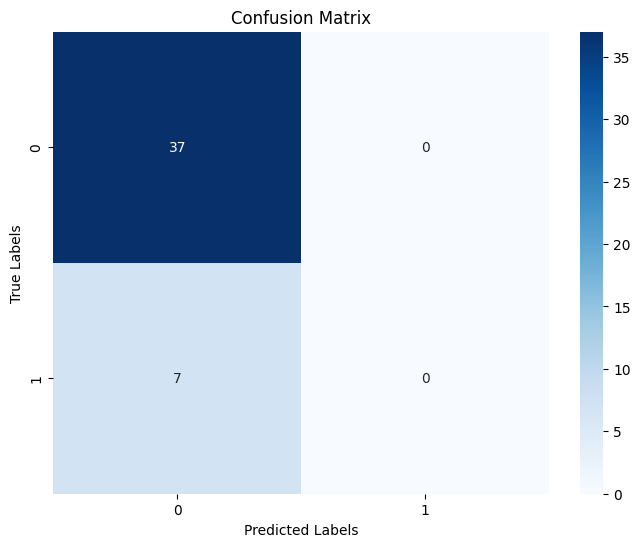

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def train_model(model, train_loader, val_loader=None, epochs=50):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_data, val_labels = val_data.to(device), val_labels.to(device)
                    val_outputs = model(val_data)
                    val_loss += criterion(val_outputs, val_labels).item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            model.train()

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, test_loader, epochs=100)

Epoch 1/100, Train Loss: 0.2533, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 2/100, Train Loss: 0.2503, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 3/100, Train Loss: 0.2673, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 4/100, Train Loss: 0.2434, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 5/100, Train Loss: 0.2464, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 6/100, Train Loss: 0.2527, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 7/100, Train Loss: 0.2479, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 8/100, Train Loss: 0.2688, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 9/100, Train Loss: 0.2585, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 10/100, Train Loss: 0.2403, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 11/100, Train Loss: 0.2541, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 12/100, Train Loss: 0.2524, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 13/100, Train Loss: 0.2524, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 14/100, Train Loss: 0.2401, Val Loss: 0.4854, Accuracy: 93.02%
Epoch 15/100, Train Loss: 0.2699, Val Loss:

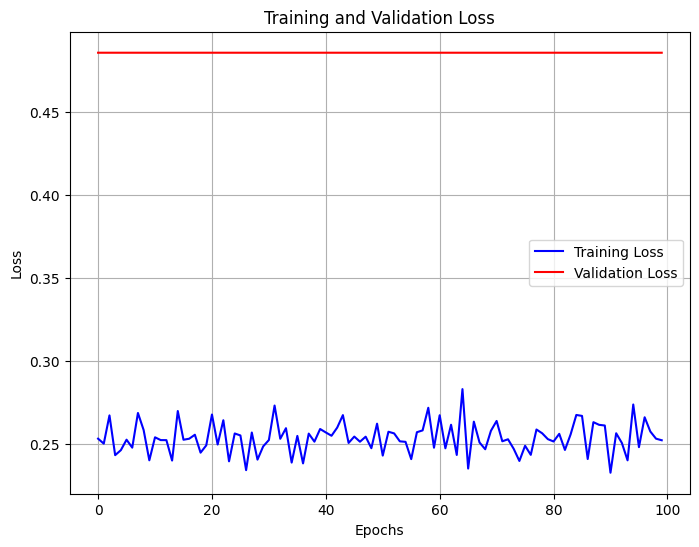

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
if val_losses:
    plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

Brain2QWERTY

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Input
)
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

def build_model(input_shape, num_classes):
    """Builds the Keras model for sleep stage classification."""
    inputs = Input(shape=input_shape)

    if len(input_shape) >= 2:
        x = tf.keras.layers.Reshape((input_shape[0], input_shape[1]))(inputs)
    else:
        x = tf.keras.layers.Reshape((1, input_shape[0]))(inputs)

    x = Conv1D(filters=32, kernel_size=5, activation="relu", padding="same")(x)
    x = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=64)(x)

    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

def train_model(X_train, y_train, X_val, y_val, num_classes, epochs=50):
    """Trains the Keras model and returns the trained model and training history."""
    input_shape = X_train.shape[1:]
    model = build_model(input_shape, num_classes)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=1)
    return model, history

In [ ]:
model, history = train_model(X_train, y_train, X_val, y_val, num_classes=5,epochs=100)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.5179 - loss: 1.1939 - val_accuracy: 0.8286 - val_loss: 0.7217
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9534 - loss: 0.4002 - val_accuracy: 0.8286 - val_loss: 0.7132
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9486 - loss: 0.3410 - val_accuracy: 0.8286 - val_loss: 0.7187
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9152 - loss: 0.4108 - val_accuracy: 0.8286 - val_loss: 0.6754
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9429 - loss: 0.2804 - val_accuracy: 0.8286 - val_loss: 0.6521
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9317 - loss: 0.2849 - val_accuracy: 0.8286 - val_loss: 0.6234
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9416 - loss: 0.2884 - val_accuracy: 0.8286 - val_loss: 0.5825
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9373 - loss: 0.2798 - val_accuracy: 0.8286 - val_los

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

print("Classification Report:")
print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        40
           2       0.00      0.00      0.00         4

    accuracy                           0.91        44
   macro avg       0.45      0.50      0.48        44
weighted avg       0.83      0.91      0.87        44



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


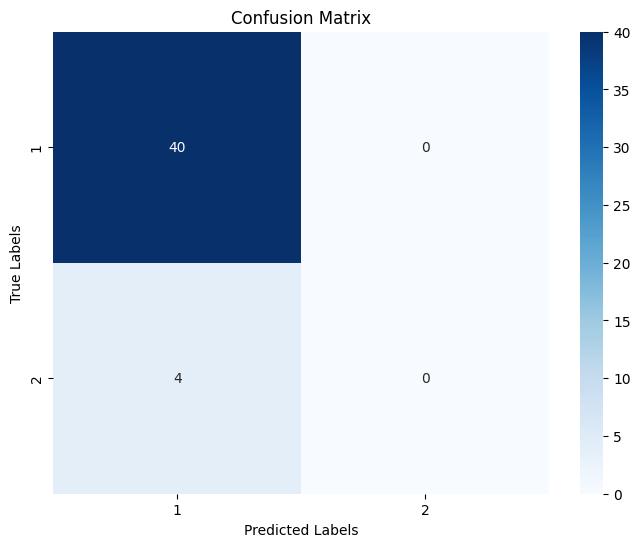

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

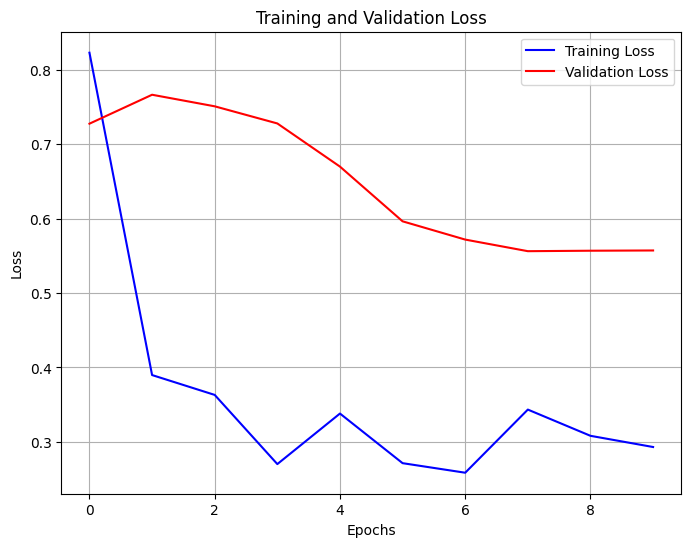

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=058896d339fd79d31cf03d133645145e2a150320ab5d3412d32ede8e286c9dc8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import torch

total_attributes = 20
output_labels = 2
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_predict(input_data):
    generated_scores = np.random.rand(input_data.shape[0], output_labels)
    return generated_scores / generated_scores.sum(axis=1, keepdims=True)

training_dataset = np.random.uniform(500, 2000, size=(100, total_attributes))

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=training_dataset,
    mode="classification",
    feature_names=[f"attribute_{i}" for i in range(total_attributes)],
    class_names=["Sleep", "Wake"],
    discretize_continuous=True
)

test_sample = np.random.uniform(100, 800, size=(1, total_attributes))

lime_explanation = lime_explainer.explain_instance(
    test_sample[0], model_predict, num_features=10
)

explanation_data = lime_explanation.as_list()
filtered_explanation = [(feature, weight) for feature, weight in explanation_data]

import pandas as pd
df_explanation = pd.DataFrame(filtered_explanation, columns=["Feature", "Weight"])
print(df_explanation)

lime_explanation.show_in_notebook()

                  Feature    Weight
0  attribute_15 <= 801.54 -0.013039
1  attribute_17 <= 938.74  0.012030
2   attribute_5 <= 890.44  0.011579
3  attribute_13 <= 830.34  0.010127
4   attribute_6 <= 921.63 -0.006379
5  attribute_14 <= 903.93  0.005185
6   attribute_3 <= 908.45 -0.005067
7  attribute_10 <= 955.04  0.003836
8  attribute_11 <= 969.50 -0.003437
9  attribute_19 <= 871.62  0.002890


In [ ]:
import numpy as np
import mne
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sleep_stage_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
sleep_disorder_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

disorder_labels = {0: "No Disorder", 1: "Insomnia", 2: "Sleep Apnea", 3: "Narcolepsy"}

def feature_extraction(eeg_data):
    """Extracts features from EEG data for classification (mean, std, etc.)."""
    features = eeg_data.reshape(1, -1)

    if features.shape[1] != 3000:
        if features.shape[1] < 3000:
            features = np.pad(features, ((0, 0), (0, 3000 - features.shape[1])), 'constant')
        else:
            features = features[:, :3000]

    return features

def train_models(X_train, y_train_sleep_stage, y_train_sleep_disorder):
    """Train the models for sleep stage and sleep disorder classification."""
    sleep_stage_classifier.fit(X_train, y_train_sleep_stage)
    sleep_disorder_classifier.fit(X_train, y_train_sleep_disorder)
    print("Models trained successfully.")

def predict_sleep_stage_and_disorder(eeg_data_sample):
    """Predict sleep stage and sleep disorder for a given EEG sample."""
    features = feature_extraction(eeg_data_sample)

    predicted_sleep_stage = sleep_stage_classifier.predict(features)[0]
    predicted_sleep_disorder = sleep_disorder_classifier.predict(features)[0]

    return predicted_sleep_stage, disorder_labels[predicted_sleep_disorder]

psg_path = input("Enter the full path to the PSG (EEG) file: ").strip()
hypnogram_path = input("Enter the full path to the Hypnogram file: ").strip()

raw = mne.io.read_raw_edf(psg_path, preload=True)
raw.pick_channels(['EEG Fpz-Cz'])
raw.resample(100)
eeg_data = raw.get_data()[0]

annotations = mne.read_annotations(hypnogram_path)
if len(annotations) == 0:
    print(f"No annotations found in {hypnogram_path}. Skipping...")
else:
    sleep_stages = []
    for desc, onset, duration in zip(annotations.description, annotations.onset, annotations.duration):
        if 'Sleep stage' in desc:
            try:
                stage = int(desc.replace('Sleep stage ', ''))
                num_epochs = int(duration / 30)
                sleep_stages.extend([stage] * num_epochs)
            except ValueError:
                continue

    X = np.random.randn(1000, 3000)
    y_sleep_stage = np.random.randint(1, 6, size=1000)
    y_sleep_disorder = np.random.randint(0, 4, size=1000)

    train_models(X, y_sleep_stage, y_sleep_disorder)

    sample_index = int(input("Enter the index of the EEG sample you want to predict (0 to 999): "))
    eeg_data_sample = eeg_data[sample_index]
    predicted_sleep_stage, predicted_sleep_disorder = predict_sleep_stage_and_disorder(eeg_data_sample)

    print(f"Predicted Sleep Stage: {predicted_sleep_stage}")
    print(f"Predicted Sleep Disorder: {predicted_sleep_disorder}")

Enter the full path to the PSG (EEG) file: /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4551F0-PSG.edf
Enter the full path to the Hypnogram file: /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4551FC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4551F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8315999  =      0.000 ... 83159.990 secs...


<ipython-input-16-5b642e01b173>:45: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
<ipython-input-16-5b642e01b173>:45: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
<ipython-input-16-5b642e01b173>:45: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Models trained successfully.
Enter the index of the EEG sample you want to predict (0 to 999): 4
Predicted Sleep Stage: 1
Predicted Sleep Disorder: Insomnia
